## Modules

In [73]:
import os
from tqdm import tqdm

import numpy as np
from scipy.signal import find_peaks, correlate, butter, sosfilt, freqs
from scipy.ndimage import gaussian_filter, median_filter
from scipy.stats import sem

import seaborn as sns
import seaborn_image as isns
import cmcrameri.cm as cmc
from matplotlib import pyplot as plt
from matplotlib import colormaps as clm

from PIL import Image
import tifffile as tff

cmap = 'cmc.batlow'
# sns.set_palette(cmap)

### Open data

In [70]:
# pathBase = r"Z:\gGermain\2024_09_12\4"
pathBase = r"Z:\gGermain\2014_09_17\3"
# N = 2
# green = np.loadtxt(pathBase + "\\530_{}.csv".format(N), skiprows=1, delimiter=',')[:,1]
# violet = np.loadtxt(pathBase + "\\405_{}.csv".format(N), skiprows=1, delimiter=',')[:,1]
# blue = np.loadtxt(pathBase + "\\470_{}.csv".format(N), skiprows=1, delimiter=',')[:,1]

green = np.loadtxt(pathBase + "\\530.csv", skiprows=1, delimiter=',')[:,1]
# violet = np.loadtxt(pathBase + "\\405.csv", skiprows=1, delimiter=',')[:,1]
blue = np.loadtxt(pathBase + "\\470.csv", skiprows=1, delimiter=',')[:,1]

sigs = (blue, green)

green_t = np.load(pathBase + "\\530ts.npy")
# violet_t = np.load(pathBase + "\\405ts.npy")
blue_t = np.load(pathBase + "\\470ts.npy")


### AP series

In [71]:
# FPS = 50
AP_idx = []
# nChannels=5
# AP_begin = 5
# percycle=15
# FPSc = FPS/nChannels
# framespcycles = int(FPSc*percycle)
# ncycles = int(len(violet_t)//framespcycles)
# AP_times = np.array(list(range(ncycles)))*15+5
AP_times = np.array([  12.01,   35.2 ,   46.51,   74.12,   91.14,  103.63,  114.48,
       132.14,  142.77,  169.61,  182.33,  197.83,  209.56,  223.5 ,
       239.35,  252.31,  263.77,  279.97,  297.53,  310.62,  323.38,
       335.92,  365.67,  383.93,  402.83,  417.51,  430.48,  440.9 ,
       456.7 ,  468.25])

for ti in AP_times:
    AP_idx.append(np.argmin(np.absolute(blue_t-ti)))

# Dirac où AP dans times series
AP_series = np.zeros(len(blue_t))
AP_series[AP_idx] = 1

In [72]:

## ALIGN DATA
inf = 30
sup = 100
aligned_data_raw = np.zeros((len(sigs), len(AP_idx), inf+sup))
aligned_data_norm = np.zeros((len(sigs), len(AP_idx), inf+sup))
for idx, sig in enumerate(sigs):
  for i in range(len(AP_idx)):
    plage = sig[int(AP_idx[i]-inf):int(AP_idx[i]+sup)]
    aligned_data_raw[idx,i,:] = plage
    aligned_data_norm[idx,i,:] = (plage-np.min(plage))/(np.max(plage)-np.min(plage))

  aligned_data = aligned_data_raw


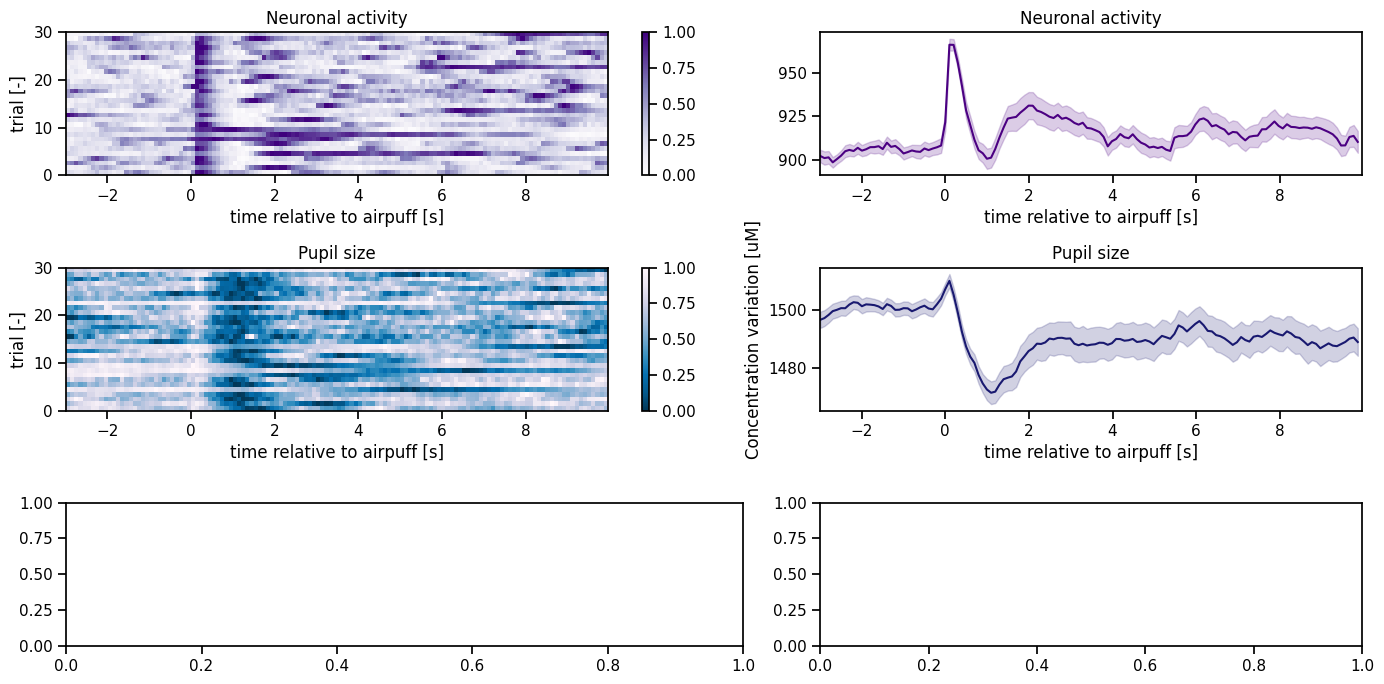

In [82]:
fig, axs = plt.subplots(3, 2, figsize=(14,7), width_ratios=[5, 4])
sns.set_context('notebook')

titles = ("Neuronal activity", "Pupil size", "Blink")
cols = ('indigo', 'midnightblue', 'midnightblue')
cmaps = (clm['Purples'], clm['PuBu_r'], clm['PuBu_r'])
time = blue_t

for idx, (sig, cmap, title) in enumerate(zip(aligned_data, cmaps, titles)):
  ax = plt.subplot(3, 2, 2*idx+1)
  ax.set_title(title)
  ax.set_xlabel('time relative to airpuff [s]')
  ax.set_ylabel("trial [-]")
  pos = ax.imshow(aligned_data_norm[idx,:,:], origin='lower', extent=[time[AP_idx[0]-inf]-time[AP_idx[0]], time[AP_idx[0]+sup]-time[AP_idx[0]], 0, len(AP_times)], aspect='auto', cmap=cmap)
  fig.colorbar(pos, ax=ax)

for idx, (sig, col, title) in enumerate(zip(aligned_data_raw, cols, titles)):
    avg_data = np.mean(sig, axis=0)
    std_data = sem(sig, axis=0)

    ax = plt.subplot(3, 2, 2*idx+2)
    ax.set_title(title)
    # ax.vlines(0, avg_data.min(), avg_data.max(), color='grey', linestyles='-')
    ax.plot(time[AP_idx[0]-inf:AP_idx[0]+sup]-time[AP_idx[0]], avg_data, color=col)
    ax.fill_between(time[AP_idx[0]-inf:AP_idx[0]+sup]-time[AP_idx[0]], avg_data-std_data, avg_data+std_data, color=col, alpha=0.2)
    ax.set_xlim(time[AP_idx[0]-inf]-time[AP_idx[0]], time[AP_idx[0]+sup]-time[AP_idx[0]])
    ax.set_xlabel('time relative to airpuff [s]')
    if idx == 1:
        ax.set_ylabel("Concentration variation [uM]")
    # sns.despine()
    plt.tight_layout()

## frames analysis

In [6]:
def identify_files(path, keywords):
    items = os.listdir(path)
    files = []
    for item in items:
        if all(keyword in item for keyword in keywords):
            files.append(item)
    files = [os.path.join(path, f) for f in files]
    files.sort(key=lambda x: os.path.getmtime(x))
    return files


def resample_pixel_value(data, bits):
    plage = 2**bits - 1
    return (plage * (data - np.min(data))/(np.max(data - np.min(data))))


def save_as_tiff(frames, prefixe, save_path):
    """_summary_

    Args:
        frames (array): 3D array of one type of data, ex HbO, HbR, or HbT
        prefixe (str): type of data
        save_path (str): folder to save data
    """
    for idx, frame in tqdm(enumerate(frames)):
        im = Image.fromarray(frame, mode='I;16')
        im.save(save_path + "\\{}.tiff".format(prefixe + str(idx)), "TIFF")


def create_npy_stack(folder_path:str, save_path:str,  wl:int, saving=False):
    """creates a 3D npy stack of raw tiff images

    Args:
        folder_path (str): folder containing tiff frames
        save_path (str): folder to save npy stack
        wl (int): wavelength for saved file name
    """
    files = identify_files(folder_path, "tif")
    # files=files[:250]
    for idx, file in tqdm(enumerate(files)):
        # frame = tff.TiffFile(folder_path+"\\"+file).asarray()
        frame = tff.TiffFile(file).asarray()
        if idx == 0:
            num_frames = len(files)
            frame_shape = frame.shape
            stack_shape = (num_frames, frame_shape[0], frame_shape[1])
            _3d_stack = np.zeros(stack_shape, dtype=np.uint16)
        _3d_stack[idx,:,:] = frame

    if saving:
        np.save(save_path+"\\{}_rawStack.npy".format(wl), _3d_stack)
    return _3d_stack


In [36]:
data_path = r"Z:\gGermain\2014_09_17\3_short"

# blue = create_npy_stack(data_path + "\\470", data_path, 470, saving=True)
# blue = np.load(data_path + "\\470_rawStack.npy")
# avg_blue = np.mean(blue, axis=0)

# dFF = (blue-avg_blue)/avg_blue
# plt.imshow(dFF[40])
# plt.show()

# dFF = gaussian_filter(dFF, sigma=2.5, axes=(1))

# # plt.imshow(dFF[40])
# dFF = resample_pixel_value(dFF, 16).astype(np.uint16)
# save_as_tiff(dFF, "GCaMP", data_path + "\\GCaMP")

601it [00:23, 25.83it/s]
